In [1]:
import tensorflow as tf
import os
from pathlib import Path

In [17]:
path = Path(os.getcwd())
root = Path(path.parent.absolute())

model_path = root / 'Models' / 'Pretrained Inception'
fetching_path = root / 'Shared Preprocessed Objects'
image_path = root / 'ROCO' / 'Data' / 'Test' / 'radiology' / 'images'

In [3]:
#target_path =  'D://Mestrado//Applications of Deep Learning//Compartmentalized_Models//Pretrained_Imagenet//'

In [4]:
word2Index = np.load(fetching_path / "word2Index.npy", allow_pickle=True).item()
index2Word = np.load(fetching_path / "index2Word.npy", allow_pickle=True).item()
variable_params = np.load(fetching_path / "variable_params.npy", allow_pickle=True).item()

test_features = np.load(model_path / "test_features_full.npy", allow_pickle=True).item()
test_captions = np.load(fetching_path / "test_captions.npy", allow_pickle=True).item()

model = tf.keras.models.load_model(model_path / 'TrainedLSTM')

In [5]:
def greedySearch(model, image_features, max_len, word2Index, index2Word):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word2Index[w] for w in in_text.split() if w in word2Index]
        #print(sequence)
        
        sequence = pad_sequences([sequence], maxlen=max_len, padding = 'post')
        #print(sequence)
        y_pred = model.predict([image_features,sequence], verbose=0)
        #print(y_pred)
        y_pred = np.argmax(y_pred)
        #print(y_pred)
        word = index2Word[y_pred]
        #print(word, y_pred)
        in_text += ' ' + word
        #print(in_text, len(in_text))
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    #print(final)
    return final

In [6]:
def beam_search_predictions(model, image_features, max_len, word2Index, index2Word, beam_index):
    start = [word2Index["startseq"]]
    start_word = [[start, 1]]
    
    final_preds = []
    live_seqs = beam_index
    image_features = np.tile(image_features, (beam_index,1))
    count = 0
    while len(start_word) > 0:
        #print(count)
        count+=1
        temp = []
        padded_seqs = []
        #Get padded seqs for each of the starting seqs so far, misnamed as start_word
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_len, padding='post')
            padded_seqs.append(par_caps)
        
        #Formatting input so that it can be used for a prediction
        padded_seqs = np.array(padded_seqs).reshape(len(start_word), max_len)
        
        preds = model.predict([image_features[:len(start_word)],padded_seqs], verbose=0)
        
        #Getting the best branches for each of the start seqs that we had
        for index, pred in enumerate(preds):
            word_preds = np.argsort(pred)[-live_seqs:]
            for w in word_preds:
                next_cap, prob = start_word[index][0][:], start_word[index][1]
                next_cap.append(w)
                prob *= pred[w]
                temp.append([next_cap, prob])
                
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words from all branches
        start_word = start_word[-live_seqs:]
        
        for pair in start_word:
            if index2Word[pair[0][-1]] == 'endseq':
                final_preds.append([pair[0][:-1], pair[1]])
                start_word = start_word[:-1]
                live_seqs -= 1
            if len(pair[0]) == max_len:
                final_preds.append(pair)
                start_word = start_word[:-1]
                live_seqs -= 1
    
    # Between all the finished sequences (either max len or predicted endseq), decide which is best
    max_prob = 0
    for index, pred in enumerate(final_preds):
        if pred[1] > max_prob:
            best_index = index
            max_prob = pred[1]
    
    # Convert to readable text
    final_pred = final_preds[best_index]
    final_caption = [index2Word[i] for i in final_pred[0]]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_prediction_single_image(model, test_image_features, test_captions, max_len, word2Index, index2Word, method, beam_index = None):
    imageIds = np.array(list(test_image_features.keys()))
    imageId = np.random.choice(imageIds, 1)[0]
    image_features = test_image_features[imageId].reshape((1,2048))
    
    #image_path = 'D://Mestrado//Applications of Deep Learning//Roco//roco-dataset//data//test//radiology//images//'
    image = plt.imread(image_path / (imageId +'.jpg'))
    plt.imshow(image)
    plt.show()
    true_caption = ' '.join(test_captions[imageId].split()[1:-1])
    
    print('True Caption: ', true_caption)
    
    if method == 'greedy':
        print("Greedy Search:", greedySearch(model, image_features, max_len, word2Index, index2Word))
    else:
        if beam_index == None:
            print("For beam search you must input a beam_index. this is any natural number")
        else:
            print("Beam Search, K = " + str(beam_index) + ":", beam_search_predictions(model, image_features, max_len, word2Index, index2Word, beam_index))

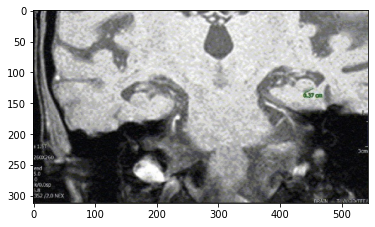

True Caption:  an hc with a diameter of 037 cm in the left hippocampus is noted in the t1weighted image at the level of the hippocampus
Beam Search, K = 10:  magnetic magnetic magnetic imaging showing a mass mass


In [25]:
# greedy is apparently broken for some reason.
generate_prediction_single_image(model, test_features, test_captions, 
                                 variable_params['max_caption_len'], word2Index, 
                                 index2Word, 'beam', beam_index = 10)